# Shutterfly Homework

This notebook is part of the interview process of Data Scientist position in Shutterfly. 

The data and description of the problem are from the GitHub page: https://github.com/sflydatascience/homework1.

My goal in this project is to predict the <b>revenue ranges</b> based on <b>customer's online behavior</b>. A more detailed description of the project is given in the beginning of Section 2.

## 1. Exploration of the Dataset

### 1.1 Initial Intepretation of the Datasets
Two data sets ('online.csv', 'order.csv') were given. 

My interpretion on these two datasets are as follows:
1. 'online.csv' is a dataset that records online activities of the users. Each entry (one row) is a visit from a certain customer ('custno') at a certain time ('dt'). We also have the online event ('event1', 'event2'), e.g. Sales, Discounts (I presume), that this visit involves, as well as the online browsing category ('category').
2. 'order.csv' is a dataset that records the orders from the users. Each entry (one row) is an order of a certain item ('prodcat1', 'prodcat2') from a certain customer ('custno'). We also have the order date ('orderdate'), order number ('ordno') and revenue of the purchase ('revenue').

We now dive a bit deeper into the structure of the datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm

tqdm.pandas()

In [2]:
# Read in the datasets
online = pd.read_csv('data/online.csv')
order = pd.read_csv('data/order.csv')

In [3]:
# Look at the data sets Briefly
print(online.shape)
online.head()

(954774, 7)


,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [4]:
print(order.shape)
order.head()

(263278, 6)


,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


There are many null values on 'event1' and 'procat2'. I think for 'event1', a null value may mean that there is no event going on. For 'prodcat2' it may mean that the product has not been categorized. For both cases it is safe to impute the nulls with some value distinct from all existing values in that column.

Before that, we first look at the number of unique values in each column.

In [5]:
online.nunique()

session     850235
visitor     259950
dt          942579
custno       57584
category         3
event1          10
event2          10
dtype: int64

In [6]:
order.nunique()

custno        70264
ordno        149717
orderdate    149482
prodcat2        251
prodcat1          6
revenue       15001
dtype: int64

We see that there are multiple items sharing a same order number, and there are multiple order numbers coming from a same customer. We also sees that 'prodcat2' should be more detailed categories than 'prodcat1'.

It should be clear that each order number corresponds to only one customer and only one order date. But I hope to verify that.

In [7]:
uniqueness = order.groupby('ordno')['custno','orderdate'].nunique().reset_index()
print(len(uniqueness[uniqueness['custno']!=1]))
print(len(uniqueness[uniqueness['orderdate']!=1]))

0
0


### 1.2 Imputing the Null values
We now investigate the null values from 'event1' and 'prodcat2'.

In [8]:
online['event1'].unique()

array([nan,  1.,  2.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

From 'event1', value '3' is missing. We will impute them with '3'.

In [9]:
online['event1'].fillna(value = 3, inplace = True)

In [10]:
order['prodcat2'].unique()

array([ nan, 256., 257.,   2., 258.,   3., 259.,   4., 260.,   5., 261.,
         6., 262.,   7., 263.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
        15.,  16.,  17.,  18.,  19.,  20.,  21.,  23.,  24.,  25.,  26.,
        27.,  28.,  30.,  32.,  33.,  34.,  35.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
        64.,  65.,  66.,  67.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  85.,  86.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

We will be more careful for 'prodcat2', since it should be the subcategory of 'prodcat1'. We will first see how many values of 'prodcat1' has when 'prodcat2' is null.

In [11]:
order[np.isnan(order['prodcat2'])]['prodcat1'].unique()

array([1, 7])

We should use different values to impute the two cases. Since 'prodcat2' is missing a lot of numbers in range (2, 264). To be safe, we will use '0' and '1' for the two cases respectively.

In [12]:
order['prodcat2'] = order.progress_apply(lambda row: row['prodcat2'] if (not np.isnan(row['prodcat2'])) else (0 if row['prodcat1']==1 else 1),axis = 1)

100%|██████████| 263278/263278 [00:06<00:00, 41192.10it/s]


## 2. Project Statement and Feature Engineering

Based on the understanding of the two datasets, I propose the following project:

<b>Prediction of Revenue Range Based on Customer's Online Behavior. </b>

### New Dataframe - Feature Engineering
I will create a new dataframe, where each entry (one row) is indexed by a unique order number ('orderno'). The new dataframe will have the following columns:

1. 'custno' - The unique (verified above) customer number from the customer that purchase the order.
2. 'orderdate' - The unique date and time the order was completed.
3. 'revenue' - The <b>total</b> revenue of the order (not the revenue for each item!). 
4. 'prodcat1_1'~'prodcat1_7' - The number of purchased items from the i-th category of prodcat1.
5. 'nhits_1week' - The number of visits from the customer number in the previous week before the order date.
6. 'nhits_3days' - The number of visits from the customer number in the previous 3 days before the order date.
7. 'nhits_1day' - The number of visits from the customer number in the previous 24 hours before the order time.
8. 'mr_event1' - The category of event1 from the customer number in his/her <b>most recent</b> visit.
9. 'mr_event2' - Same as above, but the category of event2.
10. 'mr_category' - Same as above, but the online browsing category.

### My Goal
I will then divide the data into 4 categories according to the 4 quantiles of 'revenue' (0%-25%; 25%-50%; 50%-75%, 75%-100%). My <b>goal</b> is to train an ML model that predicts which quantile a given order from a given customer will fall into.

### My Features
I will use columns 4~10 from my new dataframe as my features. Columns 5~10 represent the online activities of a given customer leading to the purchase of an order. These features will be collected from the two given datasets. I expect collinearity among the features (for instance, 'nhits_1weeks' vs 'nhits_3days'). I will apply feature selection later.

Column 4 (in fact 6 columns) gives the number of items purchased in each category of prodcat1. These show the interest of the customer in each big category.
I decide not to use a similar feature from prodcat2, for the reason that the prodcat2 is too detailed, and the small categories are almost representing the prices themselves! It doesn't make sense to use the target to predict the target. Also the number of categories in prodcat2 is >250. This will lead to a huge dimension in our feature space.

## 2.1 Creating the new DataFrame

In [13]:
# Convert the timestamps to datetime format
online['dt']=pd.to_datetime(online['dt'])
order['orderdate'] = pd.to_datetime(order['orderdate'])

In [14]:
# Create Dummies for prodcat1
order = pd.get_dummies(order, columns = ['prodcat1'])

We will create the new dataframe by first grouping the 'order.csv' according to 'ordno'. Then we will use aggregation functions to yield the needed features from order.csv

In [15]:
# Group the dataframe by order numbers
gdf = order.groupby(by = ['ordno'])

# Use aggregation function to compute the feature needed.
gdf = gdf.agg({'custno':'min', 'orderdate':'min', 'revenue':'sum', 'prodcat1_1':'sum','prodcat1_2':'sum',
         'prodcat1_3':'sum','prodcat1_4':'sum','prodcat1_5':'sum','prodcat1_7':'sum'}).reset_index()

print(gdf.shape)
gdf.head()

(149717, 10)


,ordno,custno,orderdate,revenue,prodcat1_1,prodcat1_2,prodcat1_3,prodcat1_4,prodcat1_5,prodcat1_7
0,1,1,2017-06-12 08:27:59,8.35,1,0,0,0,0,0
1,2,2,2016-03-29 13:04:27,13.58,1,0,0,0,0,0
2,3,3,2017-01-31 19:16:49,95.76,1,0,0,0,0,0
3,4,4,2017-08-14 21:22:10,33.92,1,0,0,0,0,0
4,5,5,2016-01-16 16:59:06,90.49,1,0,0,0,0,0


Our next goal is to compute the number of hits from online.csv. We will make use of the following function:

In [16]:
'''A function that returns the number of visit records from online.csv from 1 week, 3 days, 1 day (respectively) 
before the purchase''' 
def get_num_visits(custno, orderdate, list_custnos):
    if custno not in list_custnos: return 0, 0, 0
    else:
        records = online[(online['custno']==custno) & (online['dt']<orderdate)] 
        n_oneweek = len(records[records['dt']>orderdate - datetime.timedelta(days = 7)])
        n_threedays = len(records[records['dt']>orderdate - datetime.timedelta(days = 3)])
        n_oneday = len(records[records['dt']>orderdate - datetime.timedelta(hours = 24)])
        return n_oneweek, n_threedays, n_oneday

In [17]:
list_custnos = list(online['custno'].unique())
gdf['nhits_1week'], gdf['nhits_3days'], gdf['nhits_1day'] = zip(*gdf.apply(lambda row: get_num_visits(row['custno'],
                                                                                                      row['orderdate'], 
                                                                                                      list_custnos),
                                                                           axis =1))

We will now compute the activity from the most recent visit.

In [18]:
'''A function that returns the events from most recent visit. 
If the visit happens more than one weeks ago, we return 0''' 
def most_recent_record(custno, orderdate,list_custnos):
    record = online[(online['custno']==custno) & (online['dt']<orderdate)]
    if len(record) == 0: 
        return 0, 0, 0
    else:
        mr_record = record.sort_values(by = ['dt'], ascending = False).reset_index().loc[0,:]
        return mr_record['event1'], mr_record['event2'], mr_record['category']

In [19]:
gdf['mr_event1'], gdf['mr_event2'], gdf['mr_category'] = zip(*gdf.apply(lambda row: most_recent_record(row['custno'], 
                                                                                                       row['orderdate'], 
                                                                                                       list_custnos), 
                                                                        axis = 1))

In [20]:
# Transfer some columns into integer format - saving some space.
gdf = gdf.astype({'mr_event1':int, 'mr_event2':int, 'mr_category':int})

# Save the new dataframe to file.
gdf.to_csv('gdf.csv', index = False)

gdf.head()

,ordno,custno,orderdate,revenue,prodcat1_1,prodcat1_2,prodcat1_3,prodcat1_4,prodcat1_5,prodcat1_7,nhits_1week,nhits_3days,nhits_1day,mr_event1,mr_event2,mr_category
0,1,1,2017-06-12 08:27:59,8.35,1,0,0,0,0,0,0,0,0,0,0,0
1,2,2,2016-03-29 13:04:27,13.58,1,0,0,0,0,0,0,0,0,0,0,0
2,3,3,2017-01-31 19:16:49,95.76,1,0,0,0,0,0,0,0,0,0,0,0
3,4,4,2017-08-14 21:22:10,33.92,1,0,0,0,0,0,0,0,0,0,0,0
4,5,5,2016-01-16 16:59:06,90.49,1,0,0,0,0,0,0,0,0,0,0,0


## 2.2 Set target classes
I will now divide the data into 4 categories according to the 4 quantiles of 'revenue' (0%-25%; 25%-50%; 50%-75%, 75%-100%). These categories will serve as targets of our ML model.

In [21]:
gdf['revenue'].describe()

count    149717.000000
mean        131.781091
std          99.086187
min           0.010000
25%          62.510000
50%         114.240000
75%         173.180000
max        1813.100000
Name: revenue, dtype: float64

/home/xuntao/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


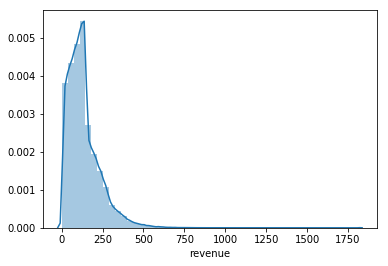

In [22]:
# Histogram for the distribution of revenue.
sns.distplot(gdf['revenue'])

In [23]:
# Check how many data points in the tail.
len(gdf[gdf['revenue']>500])

1044

We can see that there is a 'long tail' in our revenue distribution. In order to count for the long tail, it is useful to stratify our sample space into classes with equal sample sizes: that is, using quantiles.

In [24]:
def revenue_category(revenue, qt1, qt2, qt3):
    if revenue < qt1: return 1
    elif revenue < qt2: return 2
    elif revenue < qt3: return 3
    else: return 4

In [25]:
qt1 = gdf['revenue'].describe()['25%']
qt2 = gdf['revenue'].describe()['50%']
qt3 = gdf['revenue'].describe()['75%']

gdf['rev_cat'] = gdf['revenue'].apply(lambda x: revenue_category(x, qt1, qt2, qt3))

## 2.3 Feature Selection

I will now plot a correlation heatmap between our features. I will then find the pairs of features that has a high correlation, and delete one feature from each pair to avoid collinearity.

In [26]:
features = ['prodcat1_1', 'prodcat1_2','prodcat1_3','prodcat1_4','prodcat1_5','prodcat1_7','nhits_1week',
           'nhits_3days','nhits_1day','mr_event1','mr_event2','mr_category']

In [27]:
''' Input: dataframe, features
    Output: Correlation Heatmap among features.
'''
def corr_heatmap(df, features):
    df_features = df[features]
    corr = df_features.corr()
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, mask = mask, cmap = cmap)

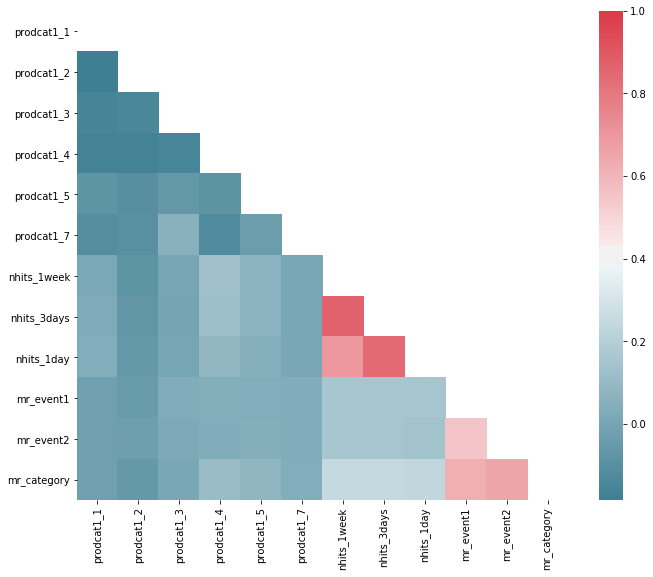

In [28]:
corr_heatmap(gdf, features)

In [29]:
''' Input: dataframe, features, a threshold of high correlation
    Output: a list of pairs of features that are highly correlated.
'''
def high_corrs(df, features, threshold = 0.9):
    df_features = df[features]
    corr = df_features.corr()
    high_corr = []
    
    for col in features:
        feature_copy = features.copy()
        feature_copy.remove(col)
        for ind in feature_copy:
            if corr.loc[ind, col] > threshold:
                if [ind, col] not in high_corr and [col, ind] not in high_corr:
                    high_corr.append([ind, col])
    return high_corr

In [30]:
high_corrs(gdf, features, 0.8)

[['nhits_3days', 'nhits_1week'], ['nhits_1day', 'nhits_3days']]

The 'nhits_3days' is the common feature in the two pairs. Removing it will reduce the correlations of all pairs below our threshold.

In [31]:
features.remove('nhits_3days')

## 3. Model Selection

### 3.1 Distribution of features
I will first investigate the distribution of our features.

In [32]:
print('Num of Zeros in mr_category', len(gdf[gdf['mr_category']==0]))
print('Num of Zeros in mr_event1', len(gdf[gdf['mr_event1']==0]))
print('Num of Zeros in mr_event2', len(gdf[gdf['mr_event2']==0]))
print('Num of Zeros in nhits_1week', len(gdf[gdf['nhits_1week']==0]))
print('Num of Zeros in nhits_3days', len(gdf[gdf['nhits_3days']==0]))
print('Num of Zeros in nhits_1day', len(gdf[gdf['nhits_1day']==0]))

Num of Zeros in mr_category 25499
Num of Zeros in mr_event1 25499
Num of Zeros in mr_event2 25499
Num of Zeros in nhits_1week 97920
Num of Zeros in nhits_3days 105133
Num of Zeros in nhits_1day 112142


In [33]:
''' Input: dataframe, features
    Output: Plots of the distribution of each feature.
'''
def features_distribution(df, features):
    plt.figure(figsize = (10,20))
    n_col = 2
    n_row = np.ceil(len(features)/2)
    i = 0
    for feature in features:
        plt.subplot(n_row, n_col, i+1)
        x = df[feature]
        sns.distplot(x, bins = 40, kde_kws = {'color': 'b'}, 
                     hist_kws={"linewidth": 1,"color": "b"})
        i = i+1
        plt.xlabel(feature)
        plt.ylabel('dist')
    plt.tight_layout()
    plt.show()

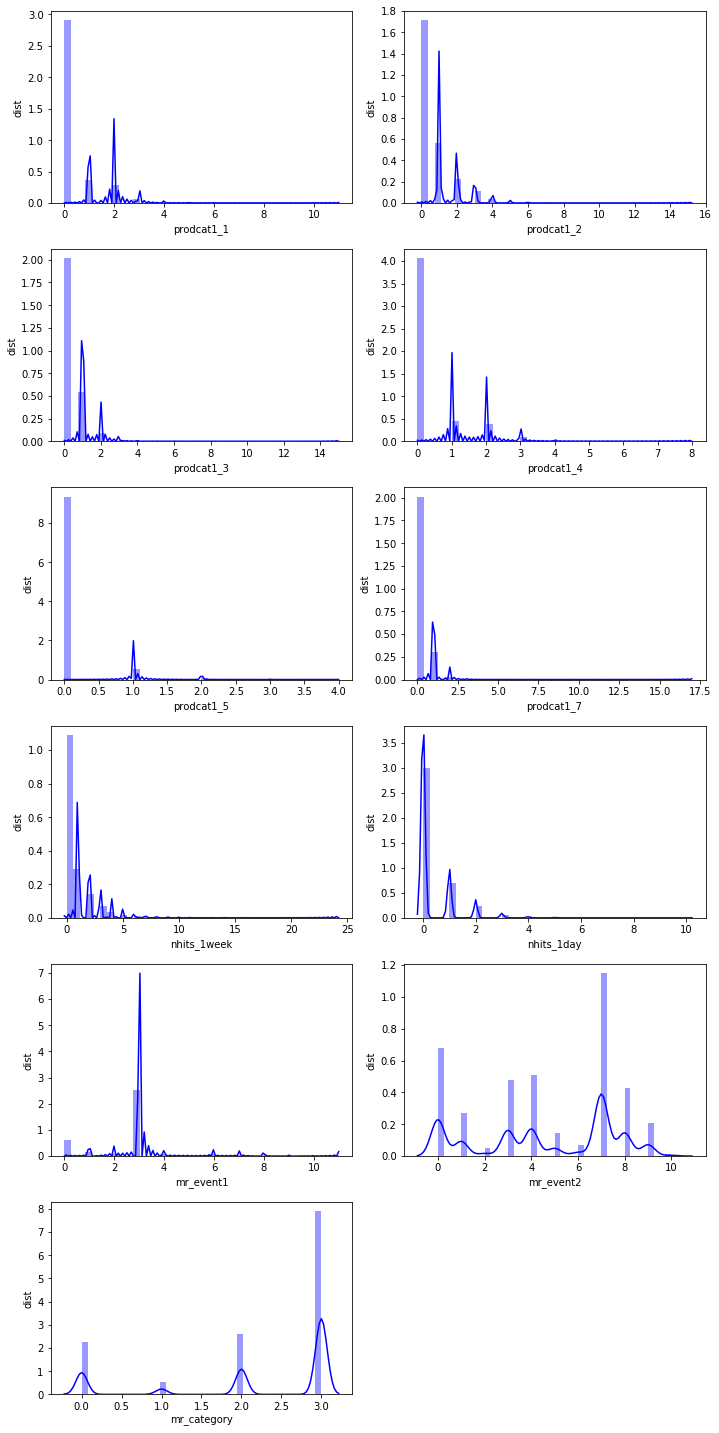

In [34]:
features_distribution(gdf, features)

There are a lot of zeros in the first 6 plot, this is as expected, since they are mostly dummy variables. There are also a lot of zeros in the 'nhits', because the period between two visits from the same person to a certain website are usually long. This is a usual behavior, we shouldn't regard them as outliers.

Due to this sparsity, it is best to use the Decision Tree methods. 

### 3.2 Decision Tree methods
I will generate suitable supervised machine learning models and evaluate them. Since I am using classifiers, I will look at cross validation accuracy as the critierion for model selection and evaluation. I will also compute the 95% confidence interval for  model accuracy. The best model will have the highest CV accuracy and the most narrow confidence interval.

I will try two classifiers: Random Forest and Logistic Regression. For Random Forest I will use GridSearchCV to choose the best parameters. For Logistic Regression I will use cross validation scores to estimate the test accuracy. Since cross validation is used in both models, I will not split the training set and test sets.

In [35]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [36]:
# Select the target and the features.
y = gdf['rev_cat']
X = gdf[features]

### 3.2.1 Random Forest

In [37]:
# Initialize model
rf = RandomForestClassifier()

# Set parameter grid.
list_estimators = range(50,150, 10)
list_depth = range(1,7)
param_grid = {'max_depth':list_depth, 'n_estimators':list_estimators}

# Apply GridSearchCV to find the best parameters.
rf_result = GridSearchCV(rf, param_grid = param_grid, cv = 5)
rf_result.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 7), 'n_estimators': range(50, 150, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Let us check out the result.

In [38]:
print('The best Random Forest Model is: ', rf_result.best_estimator_)
print('This model gives a CV prediction accuracy of ', rf_result.best_score_, '+-', 
      2*rf_result.cv_results_['std_test_score'][rf_result.best_index_])

The best Random Forest Model is:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
This model gives a CV prediction accuracy of  0.4488935792194607 +- 0.018020219424541586


### 3.2.2 Logistic Regression

In [39]:
logistic = LogisticRegression(solver = 'lbfgs', multi_class= 'multinomial', max_iter = 2000)
lg_cv_scores = cross_val_score(logistic, X, y, cv = 5)

In [40]:
print('The multi-class Logistic Regression model gives a CV prediction accuracy of ', 
      lg_cv_scores.mean(), '+-', 2*lg_cv_scores.std())

The multi-class Logistic Regression model gives a CV prediction accuracy of  0.47401290182734934 +- 0.09941386037803956


The accuracy of the Random Forest model has 95% chance lying in $[0.432, 0.466]$, while the accuracy of the Logistic Regression model has 95% chance lying in $[0.375, 0.573]$. Although the Logistic Regression gives a higher CV accuracy mean, but the Random Forest has a lower variation and hence more reliable.

# Summary

In this homework I try to predict the range of revenue of an order from the online behavior of the customers. I computed the number of hits within 1 week / 3 days / 24 hours, and the event categories from the most recent visit to quantify the online behavior of the customers, and use them as features. The distribution of revenues from orders has a long tail. I hence choose quantiles from the distribution as our target classes.

In the process of feature selection, I plotted a correlation heatmap to locate the features that have high correlations. I further removed the feature that has a high correlation with some other features to avoid collinearity.

I applied two machine learning supervised models to classify our orders. I compared them based on the cross validation accuracy. Moreover I computed the confidence intervals of the cv accuracies, in order to assess the model reliability. As a result, the confidence interval of Random Forest is $[0.432, 0.466]$, while the counterpart for Logistic Regression is $[0.375, 0.573]$. I can hence draw the conclusion that the Randowm Forest is the more reliable model, despite it has a lower mean accuracy. 

The reason for this result is that Random Forest takes the average of multiple tree classifiers, which reduces the variance. It also avoids giving a decisive feature too much weight, which improves the reliability of the model. 